In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

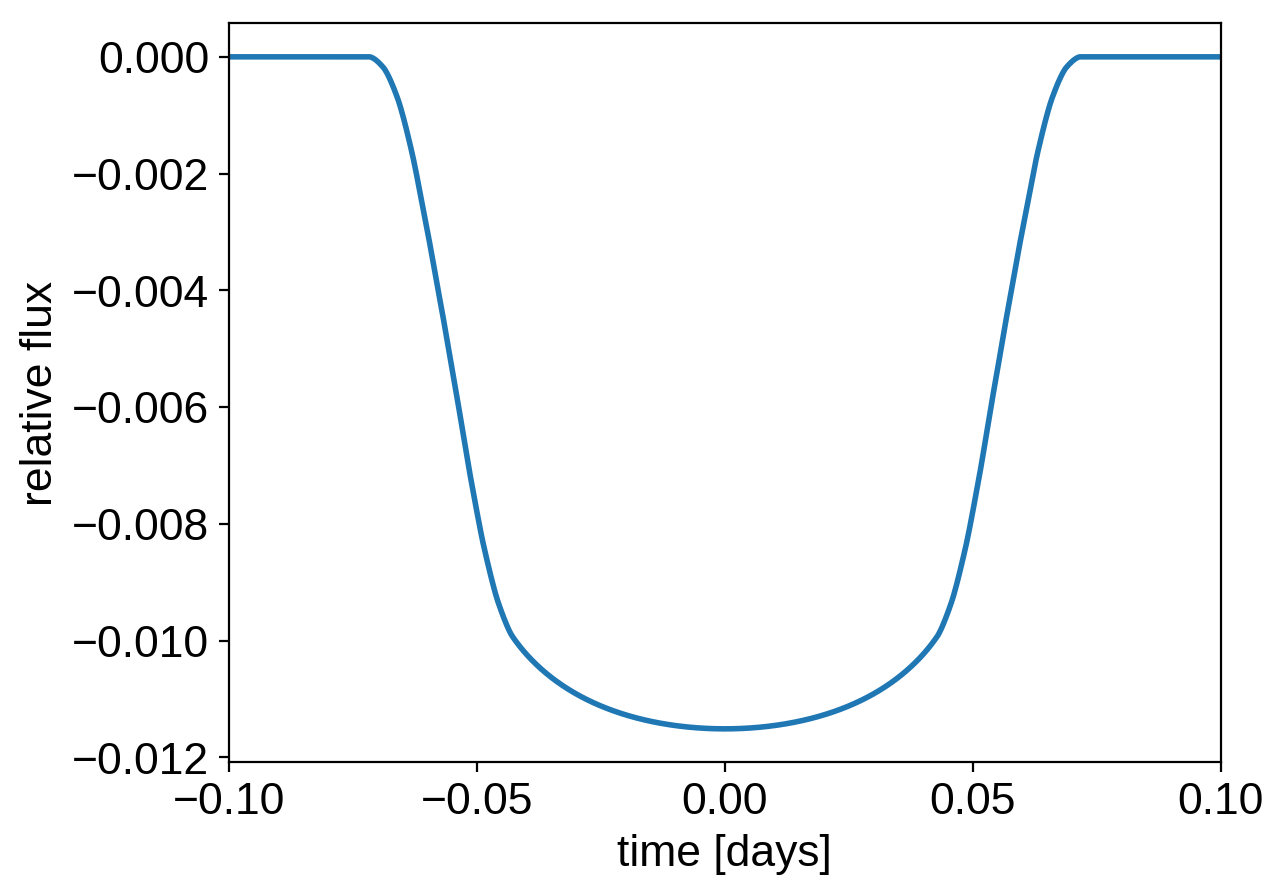

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02).eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06]))
    b = xo.distributions.ImpactParameter("b", ror=r, shape=2, testval=np.random.rand(2))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.478798e+04]

1it [00:00, 154.15it/s, logp=2.478798e+04]

2it [00:00, 231.56it/s, logp=2.478798e+04]

3it [00:00, 259.22it/s, logp=-4.973052e+09]

4it [00:00, 290.18it/s, logp=2.478859e+04] 

5it [00:00, 303.93it/s, logp=2.478913e+04]

6it [00:00, 320.75it/s, logp=2.478977e+04]

7it [00:00, 333.46it/s, logp=2.479074e+04]

8it [00:00, 340.68it/s, logp=2.478483e+04]

9it [00:00, 337.28it/s, logp=2.479082e+04]

10it [00:00, 341.37it/s, logp=2.479098e+04]

11it [00:00, 322.19it/s, logp=2.479151e+04]

12it [00:00, 302.24it/s, logp=2.479065e+04]

13it [00:00, 304.47it/s, logp=2.479174e+04]

14it [00:00, 307.60it/s, logp=2.479145e+04]

15it [00:00, 311.04it/s, logp=2.479182e+04]

16it [00:00, 311.99it/s, logp=2.479195e+04]

17it [00:00, 316.09it/s, logp=2.479239e+04]

18it [00:00, 312.03it/s, logp=2.479094e+04]

19it [00:00, 311.29it/s, logp=2.479253e+04]

20it [00:00, 309.63it/s, logp=2.479279e+04]

21it [00:00, 304.92it/s, logp=2.479323e+04]

22it [00:00, 303.28it/s, logp=2.479351e+04]

23it [00:00, 300.50it/s, logp=2.479354e+04]

24it [00:00, 298.61it/s, logp=2.479354e+04]

25it [00:00, 295.72it/s, logp=2.479354e+04]

26it [00:00, 293.11it/s, logp=2.479354e+04]

27it [00:00, 290.18it/s, logp=2.479354e+04]

28it [00:00, 286.93it/s, logp=2.479354e+04]

29it [00:00, 281.82it/s, logp=2.479354e+04]

30it [00:00, 288.26it/s, logp=2.479354e+04]

30it [00:00, 288.26it/s, logp=2.479354e+04]

31it [00:00, 288.26it/s, logp=2.479354e+04]

32it [00:00, 288.26it/s, logp=2.479354e+04]

33it [00:00, 288.26it/s, logp=2.479354e+04]

34it [00:00, 288.26it/s, logp=2.479354e+04]

35it [00:00, 288.26it/s, logp=2.479354e+04]

36it [00:00, 288.26it/s, logp=2.479354e+04]

37it [00:00, 288.26it/s, logp=2.479354e+04]

38it [00:00, 288.26it/s, logp=2.479354e+04]

39it [00:00, 288.26it/s, logp=2.479354e+04]

40it [00:00, 288.26it/s, logp=2.479354e+04]

41it [00:00, 288.26it/s, logp=2.479354e+04]

42it [00:00, 288.26it/s, logp=2.479354e+04]

43it [00:00, 288.26it/s, logp=2.479354e+04]

44it [00:00, 288.26it/s, logp=2.479354e+04]

45it [00:00, 288.26it/s, logp=2.479354e+04]

46it [00:00, 288.26it/s, logp=2.479354e+04]

47it [00:00, 288.26it/s, logp=2.479354e+04]

48it [00:00, 288.26it/s, logp=2.479354e+04]

49it [00:00, 288.26it/s, logp=2.479354e+04]

50it [00:00, 288.26it/s, logp=2.479354e+04]

51it [00:00, 288.26it/s, logp=2.479354e+04]

52it [00:00, 288.26it/s, logp=2.479354e+04]

53it [00:00, 288.26it/s, logp=2.479354e+04]

54it [00:00, 288.26it/s, logp=2.479354e+04]

55it [00:00, 288.26it/s, logp=2.479354e+04]

56it [00:00, 288.26it/s, logp=2.479354e+04]

57it [00:00, 288.26it/s, logp=2.479354e+04]

58it [00:00, 288.26it/s, logp=2.479354e+04]

59it [00:00, 288.26it/s, logp=2.479354e+04]

60it [00:00, 288.26it/s, logp=2.479354e+04]

61it [00:00, 288.26it/s, logp=2.479354e+04]

62it [00:00, 288.26it/s, logp=2.479354e+04]

63it [00:00, 288.26it/s, logp=2.479354e+04]

64it [00:00, 288.26it/s, logp=2.479354e+04]

65it [00:00, 288.26it/s, logp=2.479354e+04]

66it [00:00, 288.26it/s, logp=2.479354e+04]

67it [00:00, 288.26it/s, logp=2.479354e+04]

68it [00:00, 309.74it/s, logp=2.479354e+04]

68it [00:00, 309.74it/s, logp=2.479354e+04]

69it [00:00, 309.74it/s, logp=2.479354e+04]

70it [00:00, 309.74it/s, logp=2.479354e+04]

71it [00:00, 309.74it/s, logp=2.479354e+04]

72it [00:00, 309.74it/s, logp=2.479354e+04]

73it [00:00, 309.74it/s, logp=2.479354e+04]

74it [00:00, 309.74it/s, logp=2.479354e+04]

75it [00:00, 309.74it/s, logp=2.479354e+04]

76it [00:00, 309.74it/s, logp=2.479354e+04]

77it [00:00, 309.74it/s, logp=2.479354e+04]

78it [00:00, 309.74it/s, logp=2.479354e+04]

79it [00:00, 309.74it/s, logp=2.479354e+04]

80it [00:00, 309.74it/s, logp=2.479354e+04]

81it [00:00, 309.74it/s, logp=2.479354e+04]

82it [00:00, 309.74it/s, logp=2.479354e+04]

83it [00:00, 309.74it/s, logp=2.479354e+04]

84it [00:00, 309.74it/s, logp=2.479354e+04]

85it [00:00, 309.74it/s, logp=2.479354e+04]

86it [00:00, 309.74it/s, logp=2.479354e+04]

87it [00:00, 309.74it/s, logp=2.479354e+04]

88it [00:00, 309.74it/s, logp=2.479354e+04]

89it [00:00, 309.74it/s, logp=2.479354e+04]

90it [00:00, 309.74it/s, logp=2.479354e+04]

91it [00:00, 309.74it/s, logp=2.479354e+04]

92it [00:00, 309.74it/s, logp=2.479354e+04]

93it [00:00, 309.74it/s, logp=2.479354e+04]

94it [00:00, 309.74it/s, logp=2.479354e+04]

95it [00:00, 309.74it/s, logp=2.479354e+04]

96it [00:00, 309.74it/s, logp=2.479354e+04]

97it [00:00, 309.74it/s, logp=2.479354e+04]

98it [00:00, 309.74it/s, logp=2.479354e+04]

99it [00:05, 18.44it/s, logp=2.479354e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807487 -> 24793.5394256112


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

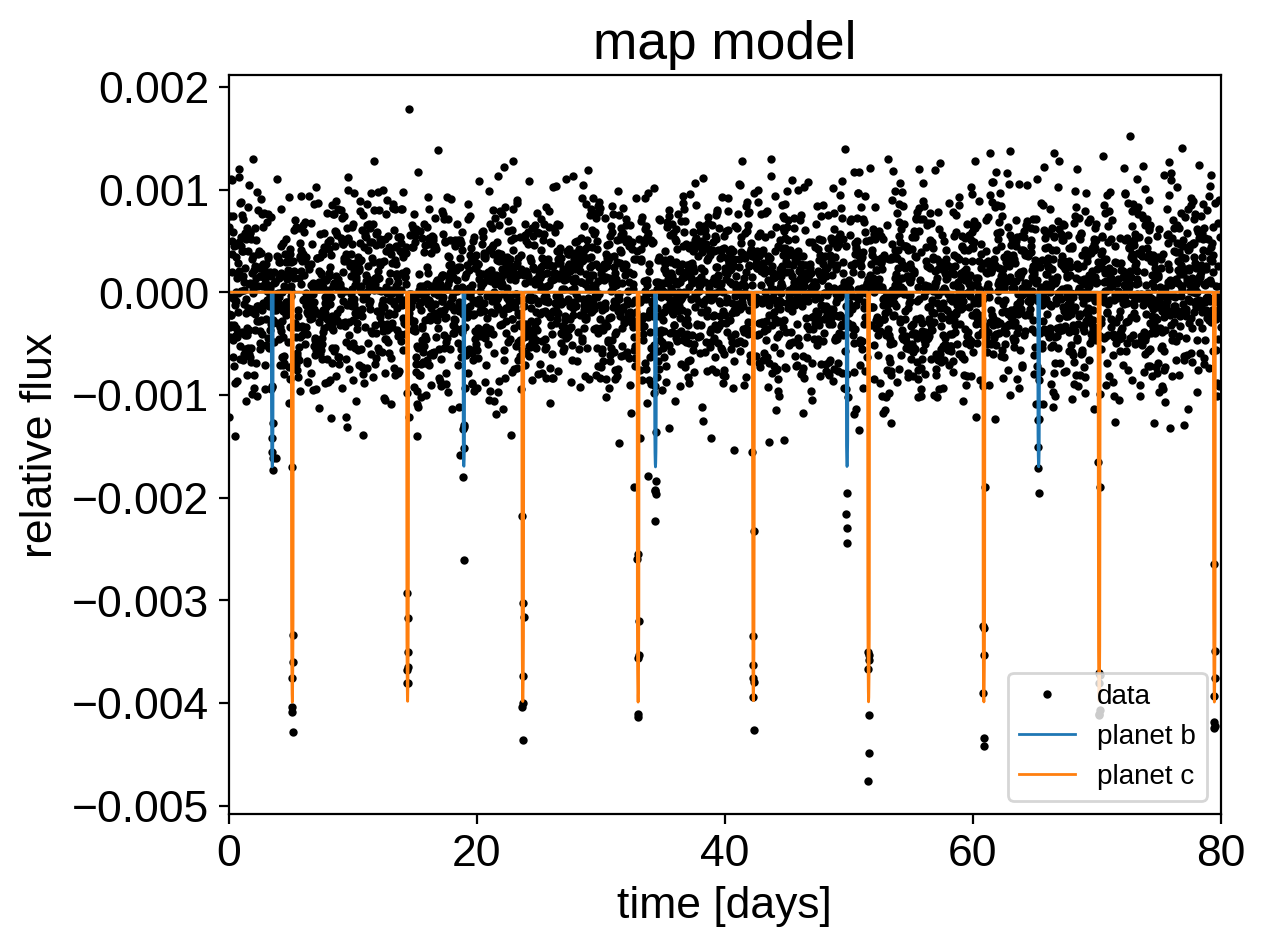

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [b, r, u, logP, t0, mean]


Sampling 4 chains:   0%|          | 0/24000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/24000 [00:00<03:12, 124.82draws/s]

Sampling 4 chains:   0%|          | 25/24000 [00:00<06:17, 63.48draws/s] 

Sampling 4 chains:   0%|          | 29/24000 [00:00<08:34, 46.62draws/s]

Sampling 4 chains:   0%|          | 33/24000 [00:00<09:35, 41.61draws/s]

Sampling 4 chains:   0%|          | 37/24000 [00:00<10:31, 37.94draws/s]

Sampling 4 chains:   0%|          | 41/24000 [00:00<12:09, 32.84draws/s]

Sampling 4 chains:   0%|          | 45/24000 [00:01<13:52, 28.76draws/s]

Sampling 4 chains:   0%|          | 49/24000 [00:01<14:38, 27.28draws/s]

Sampling 4 chains:   0%|          | 53/24000 [00:01<13:51, 28.79draws/s]

Sampling 4 chains:   0%|          | 57/24000 [00:01<13:19, 29.96draws/s]

Sampling 4 chains:   0%|          | 61/24000 [00:01<13:18, 29.99draws/s]

Sampling 4 chains:   0%|          | 65/24000 [00:01<13:07, 30.41draws/s]

Sampling 4 chains:   0%|          | 69/24000 [00:01<12:50, 31.04draws/s]

Sampling 4 chains:   0%|          | 73/24000 [00:01<12:31, 31.83draws/s]

Sampling 4 chains:   0%|          | 77/24000 [00:02<12:20, 32.31draws/s]

Sampling 4 chains:   0%|          | 81/24000 [00:02<12:15, 32.53draws/s]

Sampling 4 chains:   0%|          | 85/24000 [00:02<12:37, 31.59draws/s]

Sampling 4 chains:   0%|          | 89/24000 [00:02<12:37, 31.57draws/s]

Sampling 4 chains:   0%|          | 93/24000 [00:02<12:45, 31.23draws/s]

Sampling 4 chains:   0%|          | 97/24000 [00:02<12:57, 30.74draws/s]

Sampling 4 chains:   0%|          | 101/24000 [00:02<13:23, 29.76draws/s]

Sampling 4 chains:   0%|          | 104/24000 [00:02<13:46, 28.92draws/s]

Sampling 4 chains:   0%|          | 108/24000 [00:03<13:31, 29.43draws/s]

Sampling 4 chains:   0%|          | 112/24000 [00:03<13:38, 29.19draws/s]

Sampling 4 chains:   0%|          | 115/24000 [00:03<14:06, 28.21draws/s]

Sampling 4 chains:   0%|          | 120/24000 [00:03<13:01, 30.57draws/s]

Sampling 4 chains:   1%|          | 124/24000 [00:03<12:41, 31.37draws/s]

Sampling 4 chains:   1%|          | 128/24000 [00:03<12:28, 31.87draws/s]

Sampling 4 chains:   1%|          | 132/24000 [00:03<12:32, 31.71draws/s]

Sampling 4 chains:   1%|          | 138/24000 [00:03<11:42, 33.97draws/s]

Sampling 4 chains:   1%|          | 142/24000 [00:04<11:47, 33.74draws/s]

Sampling 4 chains:   1%|          | 146/24000 [00:04<11:47, 33.71draws/s]

Sampling 4 chains:   1%|          | 150/24000 [00:04<12:20, 32.23draws/s]

Sampling 4 chains:   1%|          | 154/24000 [00:04<12:30, 31.79draws/s]

Sampling 4 chains:   1%|          | 158/24000 [00:04<12:34, 31.58draws/s]

Sampling 4 chains:   1%|          | 162/24000 [00:04<12:56, 30.72draws/s]

Sampling 4 chains:   1%|          | 166/24000 [00:04<14:20, 27.69draws/s]

Sampling 4 chains:   1%|          | 170/24000 [00:05<13:48, 28.76draws/s]

Sampling 4 chains:   1%|          | 173/24000 [00:05<14:32, 27.30draws/s]

Sampling 4 chains:   1%|          | 176/24000 [00:05<14:46, 26.88draws/s]

Sampling 4 chains:   1%|          | 179/24000 [00:05<15:55, 24.93draws/s]

Sampling 4 chains:   1%|          | 183/24000 [00:05<15:04, 26.33draws/s]

Sampling 4 chains:   1%|          | 187/24000 [00:05<14:20, 27.67draws/s]

Sampling 4 chains:   1%|          | 191/24000 [00:05<14:05, 28.15draws/s]

Sampling 4 chains:   1%|          | 195/24000 [00:05<14:03, 28.24draws/s]

Sampling 4 chains:   1%|          | 199/24000 [00:06<13:51, 28.63draws/s]

Sampling 4 chains:   1%|          | 203/24000 [00:06<13:55, 28.48draws/s]

Sampling 4 chains:   1%|          | 207/24000 [00:06<13:36, 29.14draws/s]

Sampling 4 chains:   1%|          | 211/24000 [00:06<13:21, 29.69draws/s]

Sampling 4 chains:   1%|          | 215/24000 [00:06<13:16, 29.85draws/s]

Sampling 4 chains:   1%|          | 218/24000 [00:06<14:06, 28.10draws/s]

Sampling 4 chains:   1%|          | 222/24000 [00:06<14:29, 27.34draws/s]

Sampling 4 chains:   1%|          | 226/24000 [00:07<13:38, 29.04draws/s]

Sampling 4 chains:   1%|          | 230/24000 [00:07<13:02, 30.37draws/s]

Sampling 4 chains:   1%|          | 234/24000 [00:07<12:40, 31.27draws/s]

Sampling 4 chains:   1%|          | 238/24000 [00:07<13:02, 30.37draws/s]

Sampling 4 chains:   1%|          | 242/24000 [00:07<13:45, 28.79draws/s]

Sampling 4 chains:   1%|          | 245/24000 [00:07<14:42, 26.92draws/s]

Sampling 4 chains:   1%|          | 248/24000 [00:07<14:19, 27.64draws/s]

Sampling 4 chains:   1%|          | 252/24000 [00:07<13:36, 29.08draws/s]

Sampling 4 chains:   1%|          | 256/24000 [00:08<13:06, 30.20draws/s]

Sampling 4 chains:   1%|          | 260/24000 [00:08<13:08, 30.10draws/s]

Sampling 4 chains:   1%|          | 264/24000 [00:08<12:59, 30.44draws/s]

Sampling 4 chains:   1%|          | 268/24000 [00:08<13:21, 29.62draws/s]

Sampling 4 chains:   1%|          | 271/24000 [00:08<13:46, 28.72draws/s]

Sampling 4 chains:   1%|          | 274/24000 [00:08<13:59, 28.26draws/s]

Sampling 4 chains:   1%|          | 277/24000 [00:08<14:35, 27.08draws/s]

Sampling 4 chains:   1%|          | 281/24000 [00:08<14:17, 27.66draws/s]

Sampling 4 chains:   1%|          | 285/24000 [00:09<13:34, 29.11draws/s]

Sampling 4 chains:   1%|          | 289/24000 [00:09<13:41, 28.85draws/s]

Sampling 4 chains:   1%|          | 293/24000 [00:09<13:09, 30.02draws/s]

Sampling 4 chains:   1%|          | 297/24000 [00:09<13:11, 29.95draws/s]

Sampling 4 chains:   1%|▏         | 301/24000 [00:09<13:28, 29.32draws/s]

Sampling 4 chains:   1%|▏         | 304/24000 [00:09<13:49, 28.58draws/s]

Sampling 4 chains:   1%|▏         | 307/24000 [00:09<14:22, 27.46draws/s]

Sampling 4 chains:   1%|▏         | 310/24000 [00:09<15:06, 26.14draws/s]

Sampling 4 chains:   1%|▏         | 315/24000 [00:10<14:01, 28.16draws/s]

Sampling 4 chains:   1%|▏         | 319/24000 [00:10<13:38, 28.92draws/s]

Sampling 4 chains:   1%|▏         | 323/24000 [00:10<13:33, 29.10draws/s]

Sampling 4 chains:   1%|▏         | 327/24000 [00:10<14:21, 27.47draws/s]

Sampling 4 chains:   1%|▏         | 331/24000 [00:10<13:33, 29.11draws/s]

Sampling 4 chains:   1%|▏         | 335/24000 [00:10<13:00, 30.32draws/s]

Sampling 4 chains:   1%|▏         | 339/24000 [00:10<13:00, 30.33draws/s]

Sampling 4 chains:   1%|▏         | 343/24000 [00:11<14:20, 27.51draws/s]

Sampling 4 chains:   1%|▏         | 347/24000 [00:11<14:59, 26.29draws/s]

Sampling 4 chains:   1%|▏         | 351/24000 [00:11<15:00, 26.27draws/s]

Sampling 4 chains:   1%|▏         | 355/24000 [00:11<15:02, 26.20draws/s]

Sampling 4 chains:   1%|▏         | 359/24000 [00:11<14:38, 26.91draws/s]

Sampling 4 chains:   2%|▏         | 363/24000 [00:11<14:30, 27.14draws/s]

Sampling 4 chains:   2%|▏         | 367/24000 [00:11<14:06, 27.93draws/s]

Sampling 4 chains:   2%|▏         | 371/24000 [00:12<13:51, 28.43draws/s]

Sampling 4 chains:   2%|▏         | 374/24000 [00:12<14:43, 26.73draws/s]

Sampling 4 chains:   2%|▏         | 378/24000 [00:12<14:10, 27.76draws/s]

Sampling 4 chains:   2%|▏         | 381/24000 [00:12<14:00, 28.11draws/s]

Sampling 4 chains:   2%|▏         | 384/24000 [00:12<14:57, 26.31draws/s]

Sampling 4 chains:   2%|▏         | 387/24000 [00:12<14:31, 27.10draws/s]

Sampling 4 chains:   2%|▏         | 390/24000 [00:12<15:41, 25.08draws/s]

Sampling 4 chains:   2%|▏         | 394/24000 [00:12<15:06, 26.03draws/s]

Sampling 4 chains:   2%|▏         | 398/24000 [00:13<14:42, 26.75draws/s]

Sampling 4 chains:   2%|▏         | 401/24000 [00:13<14:20, 27.43draws/s]

Sampling 4 chains:   2%|▏         | 404/24000 [00:13<16:17, 24.14draws/s]

Sampling 4 chains:   2%|▏         | 407/24000 [00:13<15:32, 25.30draws/s]

Sampling 4 chains:   2%|▏         | 411/24000 [00:13<14:49, 26.51draws/s]

Sampling 4 chains:   2%|▏         | 415/24000 [00:13<15:18, 25.67draws/s]

Sampling 4 chains:   2%|▏         | 419/24000 [00:13<14:58, 26.23draws/s]

Sampling 4 chains:   2%|▏         | 423/24000 [00:14<14:31, 27.05draws/s]

Sampling 4 chains:   2%|▏         | 426/24000 [00:14<14:12, 27.65draws/s]

Sampling 4 chains:   2%|▏         | 430/24000 [00:14<13:55, 28.20draws/s]

Sampling 4 chains:   2%|▏         | 434/24000 [00:14<13:16, 29.57draws/s]

Sampling 4 chains:   2%|▏         | 437/24000 [00:14<14:09, 27.74draws/s]

Sampling 4 chains:   2%|▏         | 440/24000 [00:14<14:57, 26.26draws/s]

Sampling 4 chains:   2%|▏         | 443/24000 [00:14<16:07, 24.36draws/s]

Sampling 4 chains:   2%|▏         | 447/24000 [00:14<14:53, 26.35draws/s]

Sampling 4 chains:   2%|▏         | 451/24000 [00:15<14:22, 27.32draws/s]

Sampling 4 chains:   2%|▏         | 455/24000 [00:15<13:54, 28.23draws/s]

Sampling 4 chains:   2%|▏         | 459/24000 [00:15<13:35, 28.87draws/s]

Sampling 4 chains:   2%|▏         | 463/24000 [00:15<13:31, 28.99draws/s]

Sampling 4 chains:   2%|▏         | 467/24000 [00:15<13:32, 28.98draws/s]

Sampling 4 chains:   2%|▏         | 471/24000 [00:15<13:56, 28.13draws/s]

Sampling 4 chains:   2%|▏         | 475/24000 [00:15<14:37, 26.80draws/s]

Sampling 4 chains:   2%|▏         | 478/24000 [00:16<14:30, 27.03draws/s]

Sampling 4 chains:   2%|▏         | 481/24000 [00:16<14:26, 27.13draws/s]

Sampling 4 chains:   2%|▏         | 484/24000 [00:16<14:32, 26.96draws/s]

Sampling 4 chains:   2%|▏         | 488/24000 [00:16<14:08, 27.72draws/s]

Sampling 4 chains:   2%|▏         | 491/24000 [00:16<14:44, 26.58draws/s]

Sampling 4 chains:   2%|▏         | 495/24000 [00:16<13:54, 28.18draws/s]

Sampling 4 chains:   2%|▏         | 498/24000 [00:16<14:22, 27.26draws/s]

Sampling 4 chains:   2%|▏         | 502/24000 [00:16<14:02, 27.89draws/s]

Sampling 4 chains:   2%|▏         | 506/24000 [00:17<13:37, 28.75draws/s]

Sampling 4 chains:   2%|▏         | 510/24000 [00:17<13:36, 28.76draws/s]

Sampling 4 chains:   2%|▏         | 514/24000 [00:17<13:24, 29.18draws/s]

Sampling 4 chains:   2%|▏         | 517/24000 [00:17<13:48, 28.34draws/s]

Sampling 4 chains:   2%|▏         | 521/24000 [00:17<13:43, 28.52draws/s]

Sampling 4 chains:   2%|▏         | 525/24000 [00:17<13:03, 29.97draws/s]

Sampling 4 chains:   2%|▏         | 529/24000 [00:17<12:47, 30.59draws/s]

Sampling 4 chains:   2%|▏         | 533/24000 [00:17<12:48, 30.52draws/s]

Sampling 4 chains:   2%|▏         | 537/24000 [00:18<12:59, 30.10draws/s]

Sampling 4 chains:   2%|▏         | 541/24000 [00:18<12:39, 30.91draws/s]

Sampling 4 chains:   2%|▏         | 545/24000 [00:18<12:18, 31.77draws/s]

Sampling 4 chains:   2%|▏         | 549/24000 [00:18<12:03, 32.41draws/s]

Sampling 4 chains:   2%|▏         | 553/24000 [00:18<12:13, 31.95draws/s]

Sampling 4 chains:   2%|▏         | 557/24000 [00:18<12:46, 30.58draws/s]

Sampling 4 chains:   2%|▏         | 561/24000 [00:18<12:35, 31.03draws/s]

Sampling 4 chains:   2%|▏         | 565/24000 [00:18<12:20, 31.64draws/s]

Sampling 4 chains:   2%|▏         | 569/24000 [00:19<12:12, 31.97draws/s]

Sampling 4 chains:   2%|▏         | 573/24000 [00:19<12:50, 30.42draws/s]

Sampling 4 chains:   2%|▏         | 577/24000 [00:19<14:03, 27.77draws/s]

Sampling 4 chains:   2%|▏         | 582/24000 [00:19<12:44, 30.63draws/s]

Sampling 4 chains:   2%|▏         | 586/24000 [00:19<12:15, 31.85draws/s]

Sampling 4 chains:   2%|▏         | 591/24000 [00:19<12:20, 31.62draws/s]

Sampling 4 chains:   2%|▏         | 596/24000 [00:19<11:19, 34.47draws/s]

Sampling 4 chains:   3%|▎         | 603/24000 [00:20<10:19, 37.76draws/s]

Sampling 4 chains:   3%|▎         | 609/24000 [00:20<09:46, 39.90draws/s]

Sampling 4 chains:   3%|▎         | 615/24000 [00:20<08:53, 43.82draws/s]

Sampling 4 chains:   3%|▎         | 622/24000 [00:20<08:06, 48.08draws/s]

Sampling 4 chains:   3%|▎         | 628/24000 [00:20<07:39, 50.82draws/s]

Sampling 4 chains:   3%|▎         | 640/24000 [00:20<06:28, 60.17draws/s]

Sampling 4 chains:   3%|▎         | 650/24000 [00:20<05:42, 68.14draws/s]

Sampling 4 chains:   3%|▎         | 666/24000 [00:20<04:48, 80.77draws/s]

Sampling 4 chains:   3%|▎         | 692/24000 [00:20<03:49, 101.66draws/s]

Sampling 4 chains:   3%|▎         | 718/24000 [00:21<03:07, 124.36draws/s]

Sampling 4 chains:   3%|▎         | 754/24000 [00:21<02:30, 154.38draws/s]

Sampling 4 chains:   3%|▎         | 787/24000 [00:21<02:06, 183.04draws/s]

Sampling 4 chains:   3%|▎         | 822/24000 [00:21<01:49, 211.82draws/s]

Sampling 4 chains:   4%|▎         | 858/24000 [00:21<01:36, 240.41draws/s]

Sampling 4 chains:   4%|▎         | 896/24000 [00:21<01:26, 267.95draws/s]

Sampling 4 chains:   4%|▍         | 938/24000 [00:21<01:16, 299.60draws/s]

Sampling 4 chains:   4%|▍         | 982/24000 [00:21<01:09, 330.28draws/s]

Sampling 4 chains:   4%|▍         | 1020/24000 [00:21<01:10, 326.99draws/s]

Sampling 4 chains:   4%|▍         | 1059/24000 [00:21<01:07, 342.26draws/s]

Sampling 4 chains:   5%|▍         | 1101/24000 [00:22<01:03, 357.98draws/s]

Sampling 4 chains:   5%|▍         | 1139/24000 [00:22<01:03, 357.42draws/s]

Sampling 4 chains:   5%|▍         | 1178/24000 [00:22<01:03, 362.21draws/s]

Sampling 4 chains:   5%|▌         | 1222/24000 [00:22<00:59, 381.50draws/s]

Sampling 4 chains:   5%|▌         | 1262/24000 [00:22<00:59, 381.09draws/s]

Sampling 4 chains:   5%|▌         | 1305/24000 [00:22<00:57, 394.03draws/s]

Sampling 4 chains:   6%|▌         | 1352/24000 [00:22<00:54, 413.34draws/s]

Sampling 4 chains:   6%|▌         | 1403/24000 [00:22<00:52, 433.38draws/s]

Sampling 4 chains:   6%|▌         | 1455/24000 [00:22<00:49, 452.59draws/s]

Sampling 4 chains:   6%|▋         | 1508/24000 [00:22<00:48, 467.21draws/s]

Sampling 4 chains:   6%|▋         | 1556/24000 [00:23<00:48, 463.84draws/s]

Sampling 4 chains:   7%|▋         | 1603/24000 [00:23<00:48, 461.50draws/s]

Sampling 4 chains:   7%|▋         | 1650/24000 [00:23<00:49, 454.79draws/s]

Sampling 4 chains:   7%|▋         | 1696/24000 [00:23<00:49, 455.06draws/s]

Sampling 4 chains:   7%|▋         | 1742/24000 [00:23<00:49, 452.73draws/s]

Sampling 4 chains:   7%|▋         | 1788/24000 [00:23<00:48, 454.60draws/s]

Sampling 4 chains:   8%|▊         | 1834/24000 [00:23<00:49, 452.17draws/s]

Sampling 4 chains:   8%|▊         | 1880/24000 [00:23<00:52, 421.73draws/s]

Sampling 4 chains:   8%|▊         | 1927/24000 [00:23<00:50, 434.21draws/s]

Sampling 4 chains:   8%|▊         | 1971/24000 [00:24<00:51, 427.82draws/s]

Sampling 4 chains:   8%|▊         | 2015/24000 [00:24<00:57, 382.48draws/s]

Sampling 4 chains:   9%|▊         | 2060/24000 [00:24<00:54, 399.49draws/s]

Sampling 4 chains:   9%|▉         | 2102/24000 [00:24<00:54, 405.40draws/s]

Sampling 4 chains:   9%|▉         | 2150/24000 [00:24<00:51, 423.49draws/s]

Sampling 4 chains:   9%|▉         | 2194/24000 [00:24<00:51, 424.60draws/s]

Sampling 4 chains:   9%|▉         | 2237/24000 [00:24<00:53, 407.27draws/s]

Sampling 4 chains:  10%|▉         | 2284/24000 [00:24<00:51, 422.99draws/s]

Sampling 4 chains:  10%|▉         | 2329/24000 [00:24<00:50, 429.73draws/s]

Sampling 4 chains:  10%|▉         | 2377/24000 [00:25<00:48, 441.95draws/s]

Sampling 4 chains:  10%|█         | 2422/24000 [00:25<00:49, 434.27draws/s]

Sampling 4 chains:  10%|█         | 2467/24000 [00:25<00:49, 435.20draws/s]

Sampling 4 chains:  10%|█         | 2512/24000 [00:25<00:49, 437.99draws/s]

Sampling 4 chains:  11%|█         | 2556/24000 [00:25<00:49, 430.32draws/s]

Sampling 4 chains:  11%|█         | 2604/24000 [00:25<00:48, 441.87draws/s]

Sampling 4 chains:  11%|█         | 2649/24000 [00:25<00:48, 442.57draws/s]

Sampling 4 chains:  11%|█         | 2694/24000 [00:25<00:49, 427.71draws/s]

Sampling 4 chains:  11%|█▏        | 2737/24000 [00:25<00:50, 424.46draws/s]

Sampling 4 chains:  12%|█▏        | 2780/24000 [00:25<00:50, 418.33draws/s]

Sampling 4 chains:  12%|█▏        | 2826/24000 [00:26<00:49, 427.70draws/s]

Sampling 4 chains:  12%|█▏        | 2878/24000 [00:26<00:46, 451.30draws/s]

Sampling 4 chains:  12%|█▏        | 2924/24000 [00:26<00:47, 443.25draws/s]

Sampling 4 chains:  12%|█▏        | 2978/24000 [00:26<00:44, 468.36draws/s]

Sampling 4 chains:  13%|█▎        | 3031/24000 [00:26<00:43, 485.10draws/s]

Sampling 4 chains:  13%|█▎        | 3083/24000 [00:26<00:42, 494.72draws/s]

Sampling 4 chains:  13%|█▎        | 3133/24000 [00:26<00:42, 492.35draws/s]

Sampling 4 chains:  13%|█▎        | 3186/24000 [00:26<00:41, 501.89draws/s]

Sampling 4 chains:  13%|█▎        | 3237/24000 [00:26<00:41, 499.39draws/s]

Sampling 4 chains:  14%|█▎        | 3288/24000 [00:26<00:41, 498.46draws/s]

Sampling 4 chains:  14%|█▍        | 3338/24000 [00:27<00:42, 489.72draws/s]

Sampling 4 chains:  14%|█▍        | 3388/24000 [00:27<00:42, 488.42draws/s]

Sampling 4 chains:  14%|█▍        | 3437/24000 [00:27<00:43, 476.70draws/s]

Sampling 4 chains:  15%|█▍        | 3485/24000 [00:27<00:44, 460.74draws/s]

Sampling 4 chains:  15%|█▍        | 3532/24000 [00:27<00:45, 448.75draws/s]

Sampling 4 chains:  15%|█▍        | 3578/24000 [00:27<00:45, 447.58draws/s]

Sampling 4 chains:  15%|█▌        | 3627/24000 [00:27<00:44, 459.44draws/s]

Sampling 4 chains:  15%|█▌        | 3674/24000 [00:27<00:44, 457.00draws/s]

Sampling 4 chains:  16%|█▌        | 3723/24000 [00:27<00:43, 466.15draws/s]

Sampling 4 chains:  16%|█▌        | 3770/24000 [00:28<00:45, 439.85draws/s]

Sampling 4 chains:  16%|█▌        | 3817/24000 [00:28<00:45, 445.67draws/s]

Sampling 4 chains:  16%|█▌        | 3863/24000 [00:28<00:45, 446.86draws/s]

Sampling 4 chains:  16%|█▋        | 3910/24000 [00:28<00:44, 451.38draws/s]

Sampling 4 chains:  16%|█▋        | 3956/24000 [00:28<00:45, 443.81draws/s]

Sampling 4 chains:  17%|█▋        | 4004/24000 [00:28<00:44, 451.49draws/s]

Sampling 4 chains:  17%|█▋        | 4050/24000 [00:28<00:45, 441.23draws/s]

Sampling 4 chains:  17%|█▋        | 4095/24000 [00:28<00:45, 434.62draws/s]

Sampling 4 chains:  17%|█▋        | 4139/24000 [00:28<00:47, 422.54draws/s]

Sampling 4 chains:  17%|█▋        | 4196/24000 [00:28<00:43, 457.26draws/s]

Sampling 4 chains:  18%|█▊        | 4243/24000 [00:29<00:44, 448.49draws/s]

Sampling 4 chains:  18%|█▊        | 4289/24000 [00:29<00:45, 432.21draws/s]

Sampling 4 chains:  18%|█▊        | 4342/24000 [00:29<00:43, 455.05draws/s]

Sampling 4 chains:  18%|█▊        | 4390/24000 [00:29<00:42, 459.47draws/s]

Sampling 4 chains:  18%|█▊        | 4437/24000 [00:29<00:42, 456.84draws/s]

Sampling 4 chains:  19%|█▊        | 4484/24000 [00:29<00:43, 446.13draws/s]

Sampling 4 chains:  19%|█▉        | 4529/24000 [00:29<00:45, 429.01draws/s]

Sampling 4 chains:  19%|█▉        | 4574/24000 [00:29<00:44, 433.99draws/s]

Sampling 4 chains:  19%|█▉        | 4618/24000 [00:29<00:46, 418.75draws/s]

Sampling 4 chains:  19%|█▉        | 4667/24000 [00:30<00:44, 436.41draws/s]

Sampling 4 chains:  20%|█▉        | 4715/24000 [00:30<00:43, 446.37draws/s]

Sampling 4 chains:  20%|█▉        | 4761/24000 [00:30<00:42, 448.12draws/s]

Sampling 4 chains:  20%|██        | 4807/24000 [00:30<00:43, 443.22draws/s]

Sampling 4 chains:  20%|██        | 4852/24000 [00:30<00:43, 443.56draws/s]

Sampling 4 chains:  20%|██        | 4898/24000 [00:30<00:42, 445.80draws/s]

Sampling 4 chains:  21%|██        | 4946/24000 [00:30<00:41, 454.53draws/s]

Sampling 4 chains:  21%|██        | 4992/24000 [00:30<00:41, 455.03draws/s]

Sampling 4 chains:  21%|██        | 5038/24000 [00:30<00:43, 434.23draws/s]

Sampling 4 chains:  21%|██        | 5082/24000 [00:31<00:45, 412.64draws/s]

Sampling 4 chains:  21%|██▏       | 5124/24000 [00:31<00:46, 409.24draws/s]

Sampling 4 chains:  22%|██▏       | 5166/24000 [00:31<00:46, 406.58draws/s]

Sampling 4 chains:  22%|██▏       | 5207/24000 [00:31<00:47, 398.48draws/s]

Sampling 4 chains:  22%|██▏       | 5254/24000 [00:31<00:45, 413.75draws/s]

Sampling 4 chains:  22%|██▏       | 5307/24000 [00:31<00:42, 438.70draws/s]

Sampling 4 chains:  22%|██▏       | 5356/24000 [00:31<00:41, 447.85draws/s]

Sampling 4 chains:  23%|██▎       | 5405/24000 [00:31<00:40, 458.86draws/s]

Sampling 4 chains:  23%|██▎       | 5452/24000 [00:31<00:40, 460.26draws/s]

Sampling 4 chains:  23%|██▎       | 5501/24000 [00:31<00:39, 465.69draws/s]

Sampling 4 chains:  23%|██▎       | 5549/24000 [00:32<00:39, 469.81draws/s]

Sampling 4 chains:  23%|██▎       | 5597/24000 [00:32<00:38, 472.10draws/s]

Sampling 4 chains:  24%|██▎       | 5645/24000 [00:32<00:41, 446.30draws/s]

Sampling 4 chains:  24%|██▎       | 5690/24000 [00:32<00:43, 424.75draws/s]

Sampling 4 chains:  24%|██▍       | 5737/24000 [00:32<00:41, 435.00draws/s]

Sampling 4 chains:  24%|██▍       | 5781/24000 [00:32<00:42, 430.51draws/s]

Sampling 4 chains:  24%|██▍       | 5825/24000 [00:32<00:42, 431.87draws/s]

Sampling 4 chains:  24%|██▍       | 5872/24000 [00:32<00:41, 438.36draws/s]

Sampling 4 chains:  25%|██▍       | 5919/24000 [00:32<00:40, 446.52draws/s]

Sampling 4 chains:  25%|██▍       | 5964/24000 [00:33<00:40, 446.32draws/s]

Sampling 4 chains:  25%|██▌       | 6009/24000 [00:33<00:41, 434.02draws/s]

Sampling 4 chains:  25%|██▌       | 6055/24000 [00:33<00:40, 438.31draws/s]

Sampling 4 chains:  25%|██▌       | 6105/24000 [00:33<00:39, 451.39draws/s]

Sampling 4 chains:  26%|██▌       | 6157/24000 [00:33<00:38, 468.63draws/s]

Sampling 4 chains:  26%|██▌       | 6205/24000 [00:33<00:38, 465.13draws/s]

Sampling 4 chains:  26%|██▌       | 6254/24000 [00:33<00:37, 468.76draws/s]

Sampling 4 chains:  26%|██▋       | 6302/24000 [00:33<00:39, 442.88draws/s]

Sampling 4 chains:  26%|██▋       | 6351/24000 [00:33<00:39, 451.57draws/s]

Sampling 4 chains:  27%|██▋       | 6405/24000 [00:33<00:37, 473.94draws/s]

Sampling 4 chains:  27%|██▋       | 6460/24000 [00:34<00:35, 494.21draws/s]

Sampling 4 chains:  27%|██▋       | 6513/24000 [00:34<00:35, 499.36draws/s]

Sampling 4 chains:  27%|██▋       | 6564/24000 [00:34<00:35, 494.08draws/s]

Sampling 4 chains:  28%|██▊       | 6614/24000 [00:34<00:35, 485.85draws/s]

Sampling 4 chains:  28%|██▊       | 6663/24000 [00:34<00:35, 485.35draws/s]

Sampling 4 chains:  28%|██▊       | 6712/24000 [00:34<00:36, 472.89draws/s]

Sampling 4 chains:  28%|██▊       | 6760/24000 [00:34<00:36, 470.27draws/s]

Sampling 4 chains:  28%|██▊       | 6808/24000 [00:34<00:36, 466.80draws/s]

Sampling 4 chains:  29%|██▊       | 6855/24000 [00:34<00:38, 451.03draws/s]

Sampling 4 chains:  29%|██▉       | 6901/24000 [00:35<00:38, 440.57draws/s]

Sampling 4 chains:  29%|██▉       | 6946/24000 [00:35<00:39, 436.77draws/s]

Sampling 4 chains:  29%|██▉       | 6995/24000 [00:35<00:37, 447.89draws/s]

Sampling 4 chains:  29%|██▉       | 7040/24000 [00:35<00:37, 448.17draws/s]

Sampling 4 chains:  30%|██▉       | 7085/24000 [00:35<00:37, 446.53draws/s]

Sampling 4 chains:  30%|██▉       | 7130/24000 [00:35<00:37, 444.32draws/s]

Sampling 4 chains:  30%|██▉       | 7175/24000 [00:35<00:38, 439.91draws/s]

Sampling 4 chains:  30%|███       | 7223/24000 [00:35<00:37, 447.09draws/s]

Sampling 4 chains:  30%|███       | 7269/24000 [00:35<00:37, 449.61draws/s]

Sampling 4 chains:  30%|███       | 7317/24000 [00:35<00:36, 456.68draws/s]

Sampling 4 chains:  31%|███       | 7363/24000 [00:36<00:37, 441.07draws/s]

Sampling 4 chains:  31%|███       | 7413/24000 [00:36<00:36, 453.85draws/s]

Sampling 4 chains:  31%|███       | 7468/24000 [00:36<00:34, 474.09draws/s]

Sampling 4 chains:  31%|███▏      | 7516/24000 [00:36<00:35, 470.84draws/s]

Sampling 4 chains:  32%|███▏      | 7565/24000 [00:36<00:34, 474.02draws/s]

Sampling 4 chains:  32%|███▏      | 7613/24000 [00:36<00:34, 471.35draws/s]

Sampling 4 chains:  32%|███▏      | 7661/24000 [00:36<00:35, 461.81draws/s]

Sampling 4 chains:  32%|███▏      | 7708/24000 [00:36<00:35, 454.32draws/s]

Sampling 4 chains:  32%|███▏      | 7754/24000 [00:36<00:36, 448.55draws/s]

Sampling 4 chains:  32%|███▏      | 7799/24000 [00:36<00:36, 448.10draws/s]

Sampling 4 chains:  33%|███▎      | 7844/24000 [00:37<00:36, 436.82draws/s]

Sampling 4 chains:  33%|███▎      | 7888/24000 [00:37<00:37, 428.76draws/s]

Sampling 4 chains:  33%|███▎      | 7931/24000 [00:37<00:37, 428.90draws/s]

Sampling 4 chains:  33%|███▎      | 7982/24000 [00:37<00:35, 447.92draws/s]

Sampling 4 chains:  33%|███▎      | 8032/24000 [00:37<00:34, 461.03draws/s]

Sampling 4 chains:  34%|███▎      | 8079/24000 [00:37<00:34, 461.67draws/s]

Sampling 4 chains:  34%|███▍      | 8126/24000 [00:37<00:37, 425.11draws/s]

Sampling 4 chains:  34%|███▍      | 8170/24000 [00:37<00:37, 418.85draws/s]

Sampling 4 chains:  34%|███▍      | 8213/24000 [00:37<00:40, 386.26draws/s]

Sampling 4 chains:  34%|███▍      | 8253/24000 [00:38<00:41, 382.19draws/s]

Sampling 4 chains:  35%|███▍      | 8293/24000 [00:38<00:40, 386.07draws/s]

Sampling 4 chains:  35%|███▍      | 8335/24000 [00:38<00:39, 393.79draws/s]

Sampling 4 chains:  35%|███▍      | 8377/24000 [00:38<00:39, 399.55draws/s]

Sampling 4 chains:  35%|███▌      | 8420/24000 [00:38<00:38, 407.60draws/s]

Sampling 4 chains:  35%|███▌      | 8463/24000 [00:38<00:37, 411.78draws/s]

Sampling 4 chains:  35%|███▌      | 8505/24000 [00:38<00:37, 411.35draws/s]

Sampling 4 chains:  36%|███▌      | 8547/24000 [00:38<00:37, 408.56draws/s]

Sampling 4 chains:  36%|███▌      | 8591/24000 [00:38<00:36, 417.12draws/s]

Sampling 4 chains:  36%|███▌      | 8635/24000 [00:39<00:36, 423.64draws/s]

Sampling 4 chains:  36%|███▌      | 8679/24000 [00:39<00:35, 427.60draws/s]

Sampling 4 chains:  36%|███▋      | 8722/24000 [00:39<00:36, 421.92draws/s]

Sampling 4 chains:  37%|███▋      | 8765/24000 [00:39<00:36, 419.05draws/s]

Sampling 4 chains:  37%|███▋      | 8808/24000 [00:39<00:36, 420.47draws/s]

Sampling 4 chains:  37%|███▋      | 8852/24000 [00:39<00:35, 422.05draws/s]

Sampling 4 chains:  37%|███▋      | 8897/24000 [00:39<00:35, 429.63draws/s]

Sampling 4 chains:  37%|███▋      | 8941/24000 [00:39<00:35, 427.70draws/s]

Sampling 4 chains:  37%|███▋      | 8985/24000 [00:39<00:35, 425.02draws/s]

Sampling 4 chains:  38%|███▊      | 9028/24000 [00:39<00:35, 426.07draws/s]

Sampling 4 chains:  38%|███▊      | 9071/24000 [00:40<00:35, 424.88draws/s]

Sampling 4 chains:  38%|███▊      | 9121/24000 [00:40<00:33, 439.54draws/s]

Sampling 4 chains:  38%|███▊      | 9170/24000 [00:40<00:32, 452.97draws/s]

Sampling 4 chains:  38%|███▊      | 9216/24000 [00:40<00:33, 440.72draws/s]

Sampling 4 chains:  39%|███▊      | 9261/24000 [00:40<00:35, 420.61draws/s]

Sampling 4 chains:  39%|███▉      | 9304/24000 [00:40<00:35, 410.21draws/s]

Sampling 4 chains:  39%|███▉      | 9349/24000 [00:40<00:34, 420.36draws/s]

Sampling 4 chains:  39%|███▉      | 9392/24000 [00:40<00:35, 406.74draws/s]

Sampling 4 chains:  39%|███▉      | 9433/24000 [00:40<00:35, 407.47draws/s]

Sampling 4 chains:  39%|███▉      | 9474/24000 [00:40<00:36, 401.57draws/s]

Sampling 4 chains:  40%|███▉      | 9519/24000 [00:41<00:34, 414.16draws/s]

Sampling 4 chains:  40%|███▉      | 9564/24000 [00:41<00:34, 421.75draws/s]

Sampling 4 chains:  40%|████      | 9608/24000 [00:41<00:33, 424.52draws/s]

Sampling 4 chains:  40%|████      | 9658/24000 [00:41<00:32, 442.37draws/s]

Sampling 4 chains:  40%|████      | 9703/24000 [00:41<00:32, 441.25draws/s]

Sampling 4 chains:  41%|████      | 9748/24000 [00:41<00:34, 413.15draws/s]

Sampling 4 chains:  41%|████      | 9790/24000 [00:41<00:34, 410.42draws/s]

Sampling 4 chains:  41%|████      | 9832/24000 [00:41<00:34, 409.32draws/s]

Sampling 4 chains:  41%|████      | 9876/24000 [00:41<00:33, 416.59draws/s]

Sampling 4 chains:  41%|████▏     | 9923/24000 [00:42<00:32, 429.46draws/s]

Sampling 4 chains:  42%|████▏     | 9967/24000 [00:42<00:33, 419.63draws/s]

Sampling 4 chains:  42%|████▏     | 10010/24000 [00:42<00:33, 421.36draws/s]

Sampling 4 chains:  42%|████▏     | 10053/24000 [00:42<00:32, 422.88draws/s]

Sampling 4 chains:  42%|████▏     | 10101/24000 [00:42<00:31, 438.50draws/s]

Sampling 4 chains:  42%|████▏     | 10146/24000 [00:42<00:31, 439.34draws/s]

Sampling 4 chains:  42%|████▏     | 10196/24000 [00:42<00:30, 455.44draws/s]

Sampling 4 chains:  43%|████▎     | 10244/24000 [00:42<00:29, 462.31draws/s]

Sampling 4 chains:  43%|████▎     | 10291/24000 [00:42<00:29, 464.54draws/s]

Sampling 4 chains:  43%|████▎     | 10338/24000 [00:42<00:30, 448.60draws/s]

Sampling 4 chains:  43%|████▎     | 10391/24000 [00:43<00:28, 469.58draws/s]

Sampling 4 chains:  44%|████▎     | 10440/24000 [00:43<00:28, 472.30draws/s]

Sampling 4 chains:  44%|████▎     | 10490/24000 [00:43<00:28, 479.08draws/s]

Sampling 4 chains:  44%|████▍     | 10548/24000 [00:43<00:26, 501.95draws/s]

Sampling 4 chains:  44%|████▍     | 10601/24000 [00:43<00:26, 509.61draws/s]

Sampling 4 chains:  44%|████▍     | 10653/24000 [00:43<00:26, 508.58draws/s]

Sampling 4 chains:  45%|████▍     | 10705/24000 [00:43<00:25, 511.65draws/s]

Sampling 4 chains:  45%|████▍     | 10757/24000 [00:43<00:26, 503.49draws/s]

Sampling 4 chains:  45%|████▌     | 10808/24000 [00:43<00:26, 496.95draws/s]

Sampling 4 chains:  45%|████▌     | 10858/24000 [00:43<00:27, 485.28draws/s]

Sampling 4 chains:  45%|████▌     | 10907/24000 [00:44<00:27, 484.52draws/s]

Sampling 4 chains:  46%|████▌     | 10965/24000 [00:44<00:25, 506.89draws/s]

Sampling 4 chains:  46%|████▌     | 11021/24000 [00:44<00:24, 521.11draws/s]

Sampling 4 chains:  46%|████▌     | 11075/24000 [00:44<00:24, 525.51draws/s]

Sampling 4 chains:  46%|████▋     | 11128/24000 [00:44<00:24, 516.72draws/s]

Sampling 4 chains:  47%|████▋     | 11180/24000 [00:44<00:25, 506.14draws/s]

Sampling 4 chains:  47%|████▋     | 11231/24000 [00:44<00:25, 506.49draws/s]

Sampling 4 chains:  47%|████▋     | 11282/24000 [00:44<00:25, 506.90draws/s]

Sampling 4 chains:  47%|████▋     | 11333/24000 [00:44<00:25, 502.22draws/s]

Sampling 4 chains:  47%|████▋     | 11384/24000 [00:45<00:25, 496.99draws/s]

Sampling 4 chains:  48%|████▊     | 11436/24000 [00:45<00:25, 500.87draws/s]

Sampling 4 chains:  48%|████▊     | 11488/24000 [00:45<00:24, 504.92draws/s]

Sampling 4 chains:  48%|████▊     | 11539/24000 [00:45<00:25, 491.14draws/s]

Sampling 4 chains:  48%|████▊     | 11590/24000 [00:45<00:24, 496.53draws/s]

Sampling 4 chains:  49%|████▊     | 11642/24000 [00:45<00:24, 502.75draws/s]

Sampling 4 chains:  49%|████▊     | 11697/24000 [00:45<00:23, 515.48draws/s]

Sampling 4 chains:  49%|████▉     | 11752/24000 [00:45<00:23, 522.69draws/s]

Sampling 4 chains:  49%|████▉     | 11810/24000 [00:45<00:22, 538.56draws/s]

Sampling 4 chains:  49%|████▉     | 11865/24000 [00:45<00:22, 539.41draws/s]

Sampling 4 chains:  50%|████▉     | 11921/24000 [00:46<00:22, 541.76draws/s]

Sampling 4 chains:  50%|████▉     | 11978/24000 [00:46<00:21, 547.85draws/s]

Sampling 4 chains:  50%|█████     | 12036/24000 [00:46<00:21, 553.34draws/s]

Sampling 4 chains:  50%|█████     | 12094/24000 [00:46<00:21, 560.41draws/s]

Sampling 4 chains:  51%|█████     | 12151/24000 [00:46<00:21, 555.61draws/s]

Sampling 4 chains:  51%|█████     | 12207/24000 [00:46<00:23, 511.72draws/s]

Sampling 4 chains:  51%|█████     | 12259/24000 [00:46<00:24, 481.59draws/s]

Sampling 4 chains:  51%|█████▏    | 12309/24000 [00:46<00:24, 484.51draws/s]

Sampling 4 chains:  52%|█████▏    | 12362/24000 [00:46<00:23, 496.64draws/s]

Sampling 4 chains:  52%|█████▏    | 12417/24000 [00:47<00:22, 507.49draws/s]

Sampling 4 chains:  52%|█████▏    | 12470/24000 [00:47<00:22, 511.61draws/s]

Sampling 4 chains:  52%|█████▏    | 12522/24000 [00:47<00:22, 505.87draws/s]

Sampling 4 chains:  52%|█████▏    | 12574/24000 [00:47<00:22, 506.98draws/s]

Sampling 4 chains:  53%|█████▎    | 12629/24000 [00:47<00:22, 516.47draws/s]

Sampling 4 chains:  53%|█████▎    | 12682/24000 [00:47<00:21, 519.28draws/s]

Sampling 4 chains:  53%|█████▎    | 12737/24000 [00:47<00:21, 525.90draws/s]

Sampling 4 chains:  53%|█████▎    | 12793/24000 [00:47<00:21, 533.57draws/s]

Sampling 4 chains:  54%|█████▎    | 12848/24000 [00:47<00:20, 534.50draws/s]

Sampling 4 chains:  54%|█████▍    | 12904/24000 [00:47<00:20, 539.78draws/s]

Sampling 4 chains:  54%|█████▍    | 12959/24000 [00:48<00:20, 533.17draws/s]

Sampling 4 chains:  54%|█████▍    | 13013/24000 [00:48<00:20, 526.26draws/s]

Sampling 4 chains:  54%|█████▍    | 13068/24000 [00:48<00:20, 532.24draws/s]

Sampling 4 chains:  55%|█████▍    | 13122/24000 [00:48<00:20, 532.43draws/s]

Sampling 4 chains:  55%|█████▍    | 13177/24000 [00:48<00:20, 533.44draws/s]

Sampling 4 chains:  55%|█████▌    | 13234/24000 [00:48<00:19, 542.98draws/s]

Sampling 4 chains:  55%|█████▌    | 13289/24000 [00:48<00:20, 534.37draws/s]

Sampling 4 chains:  56%|█████▌    | 13344/24000 [00:48<00:19, 534.83draws/s]

Sampling 4 chains:  56%|█████▌    | 13400/24000 [00:48<00:19, 536.35draws/s]

Sampling 4 chains:  56%|█████▌    | 13455/24000 [00:48<00:19, 539.36draws/s]

Sampling 4 chains:  56%|█████▋    | 13509/24000 [00:49<00:19, 526.70draws/s]

Sampling 4 chains:  57%|█████▋    | 13562/24000 [00:49<00:19, 527.07draws/s]

Sampling 4 chains:  57%|█████▋    | 13615/24000 [00:49<00:19, 524.71draws/s]

Sampling 4 chains:  57%|█████▋    | 13668/24000 [00:49<00:19, 519.30draws/s]

Sampling 4 chains:  57%|█████▋    | 13721/24000 [00:49<00:19, 515.38draws/s]

Sampling 4 chains:  57%|█████▋    | 13773/24000 [00:49<00:20, 500.12draws/s]

Sampling 4 chains:  58%|█████▊    | 13824/24000 [00:49<00:20, 497.58draws/s]

Sampling 4 chains:  58%|█████▊    | 13877/24000 [00:49<00:20, 501.85draws/s]

Sampling 4 chains:  58%|█████▊    | 13929/24000 [00:49<00:19, 506.41draws/s]

Sampling 4 chains:  58%|█████▊    | 13980/24000 [00:50<00:19, 501.57draws/s]

Sampling 4 chains:  58%|█████▊    | 14035/24000 [00:50<00:19, 510.53draws/s]

Sampling 4 chains:  59%|█████▊    | 14089/24000 [00:50<00:19, 518.31draws/s]

Sampling 4 chains:  59%|█████▉    | 14142/24000 [00:50<00:19, 518.80draws/s]

Sampling 4 chains:  59%|█████▉    | 14194/24000 [00:50<00:20, 486.53draws/s]

Sampling 4 chains:  59%|█████▉    | 14244/24000 [00:50<00:20, 484.12draws/s]

Sampling 4 chains:  60%|█████▉    | 14294/24000 [00:50<00:19, 487.90draws/s]

Sampling 4 chains:  60%|█████▉    | 14344/24000 [00:50<00:19, 483.33draws/s]

Sampling 4 chains:  60%|█████▉    | 14396/24000 [00:50<00:19, 493.67draws/s]

Sampling 4 chains:  60%|██████    | 14450/24000 [00:50<00:18, 504.15draws/s]

Sampling 4 chains:  60%|██████    | 14509/24000 [00:51<00:18, 525.42draws/s]

Sampling 4 chains:  61%|██████    | 14565/24000 [00:51<00:17, 535.18draws/s]

Sampling 4 chains:  61%|██████    | 14620/24000 [00:51<00:17, 532.61draws/s]

Sampling 4 chains:  61%|██████    | 14678/24000 [00:51<00:17, 541.93draws/s]

Sampling 4 chains:  61%|██████▏   | 14735/24000 [00:51<00:16, 549.05draws/s]

Sampling 4 chains:  62%|██████▏   | 14791/24000 [00:51<00:17, 536.14draws/s]

Sampling 4 chains:  62%|██████▏   | 14845/24000 [00:51<00:17, 517.58draws/s]

Sampling 4 chains:  62%|██████▏   | 14899/24000 [00:51<00:17, 519.34draws/s]

Sampling 4 chains:  62%|██████▏   | 14956/24000 [00:51<00:17, 530.79draws/s]

Sampling 4 chains:  63%|██████▎   | 15010/24000 [00:51<00:16, 533.47draws/s]

Sampling 4 chains:  63%|██████▎   | 15064/24000 [00:52<00:16, 530.67draws/s]

Sampling 4 chains:  63%|██████▎   | 15119/24000 [00:52<00:16, 533.60draws/s]

Sampling 4 chains:  63%|██████▎   | 15173/24000 [00:52<00:16, 534.54draws/s]

Sampling 4 chains:  63%|██████▎   | 15227/24000 [00:52<00:16, 527.47draws/s]

Sampling 4 chains:  64%|██████▎   | 15280/24000 [00:52<00:16, 516.40draws/s]

Sampling 4 chains:  64%|██████▍   | 15334/24000 [00:52<00:16, 522.14draws/s]

Sampling 4 chains:  64%|██████▍   | 15391/24000 [00:52<00:16, 531.93draws/s]

Sampling 4 chains:  64%|██████▍   | 15451/24000 [00:52<00:15, 549.05draws/s]

Sampling 4 chains:  65%|██████▍   | 15507/24000 [00:52<00:15, 540.22draws/s]

Sampling 4 chains:  65%|██████▍   | 15562/24000 [00:53<00:15, 538.73draws/s]

Sampling 4 chains:  65%|██████▌   | 15616/24000 [00:53<00:15, 538.27draws/s]

Sampling 4 chains:  65%|██████▌   | 15670/24000 [00:53<00:15, 529.76draws/s]

Sampling 4 chains:  66%|██████▌   | 15724/24000 [00:53<00:15, 526.44draws/s]

Sampling 4 chains:  66%|██████▌   | 15777/24000 [00:53<00:15, 521.69draws/s]

Sampling 4 chains:  66%|██████▌   | 15837/24000 [00:53<00:15, 541.05draws/s]

Sampling 4 chains:  66%|██████▌   | 15893/24000 [00:53<00:14, 545.96draws/s]

Sampling 4 chains:  66%|██████▋   | 15948/24000 [00:53<00:15, 507.96draws/s]

Sampling 4 chains:  67%|██████▋   | 16000/24000 [00:53<00:16, 494.13draws/s]

Sampling 4 chains:  67%|██████▋   | 16052/24000 [00:53<00:15, 500.68draws/s]

Sampling 4 chains:  67%|██████▋   | 16108/24000 [00:54<00:15, 515.54draws/s]

Sampling 4 chains:  67%|██████▋   | 16161/24000 [00:54<00:15, 518.55draws/s]

Sampling 4 chains:  68%|██████▊   | 16214/24000 [00:54<00:15, 511.80draws/s]

Sampling 4 chains:  68%|██████▊   | 16266/24000 [00:54<00:15, 507.23draws/s]

Sampling 4 chains:  68%|██████▊   | 16319/24000 [00:54<00:15, 511.36draws/s]

Sampling 4 chains:  68%|██████▊   | 16375/24000 [00:54<00:14, 524.76draws/s]

Sampling 4 chains:  68%|██████▊   | 16428/24000 [00:54<00:14, 523.44draws/s]

Sampling 4 chains:  69%|██████▊   | 16481/24000 [00:54<00:14, 523.11draws/s]

Sampling 4 chains:  69%|██████▉   | 16534/24000 [00:54<00:14, 524.17draws/s]

Sampling 4 chains:  69%|██████▉   | 16587/24000 [00:54<00:14, 515.07draws/s]

Sampling 4 chains:  69%|██████▉   | 16643/24000 [00:55<00:13, 527.04draws/s]

Sampling 4 chains:  70%|██████▉   | 16701/24000 [00:55<00:13, 538.81draws/s]

Sampling 4 chains:  70%|██████▉   | 16756/24000 [00:55<00:13, 529.96draws/s]

Sampling 4 chains:  70%|███████   | 16810/24000 [00:55<00:13, 527.54draws/s]

Sampling 4 chains:  70%|███████   | 16865/24000 [00:55<00:13, 534.00draws/s]

Sampling 4 chains:  70%|███████   | 16919/24000 [00:55<00:13, 517.21draws/s]

Sampling 4 chains:  71%|███████   | 16971/24000 [00:55<00:13, 513.67draws/s]

Sampling 4 chains:  71%|███████   | 17023/24000 [00:55<00:13, 506.71draws/s]

Sampling 4 chains:  71%|███████   | 17075/24000 [00:55<00:13, 509.75draws/s]

Sampling 4 chains:  71%|███████▏  | 17127/24000 [00:56<00:13, 508.79draws/s]

Sampling 4 chains:  72%|███████▏  | 17178/24000 [00:56<00:13, 503.34draws/s]

Sampling 4 chains:  72%|███████▏  | 17229/24000 [00:56<00:13, 502.95draws/s]

Sampling 4 chains:  72%|███████▏  | 17280/24000 [00:56<00:13, 502.15draws/s]

Sampling 4 chains:  72%|███████▏  | 17331/24000 [00:56<00:13, 498.52draws/s]

Sampling 4 chains:  72%|███████▏  | 17382/24000 [00:56<00:13, 499.69draws/s]

Sampling 4 chains:  73%|███████▎  | 17434/24000 [00:56<00:13, 503.55draws/s]

Sampling 4 chains:  73%|███████▎  | 17489/24000 [00:56<00:12, 513.83draws/s]

Sampling 4 chains:  73%|███████▎  | 17546/24000 [00:56<00:12, 529.23draws/s]

Sampling 4 chains:  73%|███████▎  | 17601/24000 [00:56<00:12, 532.42draws/s]

Sampling 4 chains:  74%|███████▎  | 17655/24000 [00:57<00:12, 515.35draws/s]

Sampling 4 chains:  74%|███████▍  | 17707/24000 [00:57<00:13, 483.52draws/s]

Sampling 4 chains:  74%|███████▍  | 17758/24000 [00:57<00:12, 490.84draws/s]

Sampling 4 chains:  74%|███████▍  | 17813/24000 [00:57<00:12, 503.12draws/s]

Sampling 4 chains:  74%|███████▍  | 17871/24000 [00:57<00:11, 521.02draws/s]

Sampling 4 chains:  75%|███████▍  | 17928/24000 [00:57<00:11, 530.09draws/s]

Sampling 4 chains:  75%|███████▍  | 17982/24000 [00:57<00:11, 519.30draws/s]

Sampling 4 chains:  75%|███████▌  | 18035/24000 [00:57<00:11, 517.36draws/s]

Sampling 4 chains:  75%|███████▌  | 18089/24000 [00:57<00:11, 523.28draws/s]

Sampling 4 chains:  76%|███████▌  | 18142/24000 [00:58<00:11, 523.99draws/s]

Sampling 4 chains:  76%|███████▌  | 18197/24000 [00:58<00:10, 528.58draws/s]

Sampling 4 chains:  76%|███████▌  | 18250/24000 [00:58<00:11, 521.66draws/s]

Sampling 4 chains:  76%|███████▋  | 18303/24000 [00:58<00:11, 501.14draws/s]

Sampling 4 chains:  76%|███████▋  | 18354/24000 [00:58<00:11, 499.97draws/s]

Sampling 4 chains:  77%|███████▋  | 18407/24000 [00:58<00:11, 508.36draws/s]

Sampling 4 chains:  77%|███████▋  | 18462/24000 [00:58<00:10, 519.64draws/s]

Sampling 4 chains:  77%|███████▋  | 18515/24000 [00:58<00:10, 520.67draws/s]

Sampling 4 chains:  77%|███████▋  | 18571/24000 [00:58<00:10, 530.99draws/s]

Sampling 4 chains:  78%|███████▊  | 18625/24000 [00:58<00:11, 461.70draws/s]

Sampling 4 chains:  78%|███████▊  | 18673/24000 [00:59<00:12, 421.14draws/s]

Sampling 4 chains:  78%|███████▊  | 18718/24000 [00:59<00:12, 417.25draws/s]

Sampling 4 chains:  78%|███████▊  | 18762/24000 [00:59<00:12, 418.64draws/s]

Sampling 4 chains:  78%|███████▊  | 18808/24000 [00:59<00:12, 429.61draws/s]

Sampling 4 chains:  79%|███████▊  | 18855/24000 [00:59<00:11, 438.98draws/s]

Sampling 4 chains:  79%|███████▉  | 18900/24000 [00:59<00:12, 423.77draws/s]

Sampling 4 chains:  79%|███████▉  | 18943/24000 [00:59<00:12, 412.78draws/s]

Sampling 4 chains:  79%|███████▉  | 18985/24000 [00:59<00:12, 405.93draws/s]

Sampling 4 chains:  79%|███████▉  | 19034/24000 [00:59<00:11, 427.71draws/s]

Sampling 4 chains:  80%|███████▉  | 19080/24000 [01:00<00:11, 436.35draws/s]

Sampling 4 chains:  80%|███████▉  | 19130/24000 [01:00<00:10, 451.50draws/s]

Sampling 4 chains:  80%|███████▉  | 19180/24000 [01:00<00:10, 463.73draws/s]

Sampling 4 chains:  80%|████████  | 19231/24000 [01:00<00:10, 475.83draws/s]

Sampling 4 chains:  80%|████████  | 19279/24000 [01:00<00:10, 471.46draws/s]

Sampling 4 chains:  81%|████████  | 19327/24000 [01:00<00:10, 445.92draws/s]

Sampling 4 chains:  81%|████████  | 19373/24000 [01:00<00:10, 440.10draws/s]

Sampling 4 chains:  81%|████████  | 19419/24000 [01:00<00:10, 443.07draws/s]

Sampling 4 chains:  81%|████████  | 19468/24000 [01:00<00:09, 455.71draws/s]

Sampling 4 chains:  81%|████████▏ | 19522/24000 [01:01<00:09, 475.09draws/s]

Sampling 4 chains:  82%|████████▏ | 19578/24000 [01:01<00:08, 496.63draws/s]

Sampling 4 chains:  82%|████████▏ | 19629/24000 [01:01<00:08, 487.77draws/s]

Sampling 4 chains:  82%|████████▏ | 19679/24000 [01:01<00:09, 436.51draws/s]

Sampling 4 chains:  82%|████████▏ | 19724/24000 [01:01<00:09, 432.55draws/s]

Sampling 4 chains:  82%|████████▏ | 19779/24000 [01:01<00:09, 461.53draws/s]

Sampling 4 chains:  83%|████████▎ | 19835/24000 [01:01<00:08, 487.06draws/s]

Sampling 4 chains:  83%|████████▎ | 19889/24000 [01:01<00:08, 495.13draws/s]

Sampling 4 chains:  83%|████████▎ | 19942/24000 [01:01<00:08, 504.08draws/s]

Sampling 4 chains:  83%|████████▎ | 19994/24000 [01:01<00:07, 504.83draws/s]

Sampling 4 chains:  84%|████████▎ | 20048/24000 [01:02<00:07, 514.28draws/s]

Sampling 4 chains:  84%|████████▍ | 20106/24000 [01:02<00:07, 531.74draws/s]

Sampling 4 chains:  84%|████████▍ | 20160/24000 [01:02<00:07, 531.82draws/s]

Sampling 4 chains:  84%|████████▍ | 20215/24000 [01:02<00:07, 536.41draws/s]

Sampling 4 chains:  84%|████████▍ | 20271/24000 [01:02<00:06, 541.71draws/s]

Sampling 4 chains:  85%|████████▍ | 20326/24000 [01:02<00:06, 534.25draws/s]

Sampling 4 chains:  85%|████████▍ | 20382/24000 [01:02<00:06, 539.36draws/s]

Sampling 4 chains:  85%|████████▌ | 20437/24000 [01:02<00:06, 542.49draws/s]

Sampling 4 chains:  85%|████████▌ | 20492/24000 [01:02<00:06, 544.37draws/s]

Sampling 4 chains:  86%|████████▌ | 20547/24000 [01:03<00:06, 535.89draws/s]

Sampling 4 chains:  86%|████████▌ | 20601/24000 [01:03<00:06, 518.35draws/s]

Sampling 4 chains:  86%|████████▌ | 20657/24000 [01:03<00:06, 529.15draws/s]

Sampling 4 chains:  86%|████████▋ | 20711/24000 [01:03<00:06, 529.21draws/s]

Sampling 4 chains:  87%|████████▋ | 20765/24000 [01:03<00:06, 500.79draws/s]

Sampling 4 chains:  87%|████████▋ | 20816/24000 [01:03<00:06, 496.58draws/s]

Sampling 4 chains:  87%|████████▋ | 20866/24000 [01:03<00:06, 486.85draws/s]

Sampling 4 chains:  87%|████████▋ | 20915/24000 [01:03<00:06, 481.09draws/s]

Sampling 4 chains:  87%|████████▋ | 20968/24000 [01:03<00:06, 493.35draws/s]

Sampling 4 chains:  88%|████████▊ | 21024/24000 [01:03<00:05, 511.06draws/s]

Sampling 4 chains:  88%|████████▊ | 21076/24000 [01:04<00:05, 508.31draws/s]

Sampling 4 chains:  88%|████████▊ | 21128/24000 [01:04<00:05, 503.28draws/s]

Sampling 4 chains:  88%|████████▊ | 21179/24000 [01:04<00:05, 474.31draws/s]

Sampling 4 chains:  88%|████████▊ | 21227/24000 [01:04<00:05, 465.81draws/s]

Sampling 4 chains:  89%|████████▊ | 21285/24000 [01:04<00:05, 495.01draws/s]

Sampling 4 chains:  89%|████████▉ | 21340/24000 [01:04<00:05, 508.05draws/s]

Sampling 4 chains:  89%|████████▉ | 21394/24000 [01:04<00:05, 514.41draws/s]

Sampling 4 chains:  89%|████████▉ | 21449/24000 [01:04<00:04, 523.46draws/s]

Sampling 4 chains:  90%|████████▉ | 21503/24000 [01:04<00:04, 526.90draws/s]

Sampling 4 chains:  90%|████████▉ | 21556/24000 [01:05<00:04, 507.05draws/s]

Sampling 4 chains:  90%|█████████ | 21608/24000 [01:05<00:04, 502.55draws/s]

Sampling 4 chains:  90%|█████████ | 21659/24000 [01:05<00:04, 480.79draws/s]

Sampling 4 chains:  90%|█████████ | 21711/24000 [01:05<00:04, 487.15draws/s]

Sampling 4 chains:  91%|█████████ | 21767/24000 [01:05<00:04, 505.57draws/s]

Sampling 4 chains:  91%|█████████ | 21821/24000 [01:05<00:04, 511.25draws/s]

Sampling 4 chains:  91%|█████████ | 21873/24000 [01:05<00:04, 513.10draws/s]

Sampling 4 chains:  91%|█████████▏| 21925/24000 [01:05<00:04, 513.73draws/s]

Sampling 4 chains:  92%|█████████▏| 21977/24000 [01:05<00:03, 509.33draws/s]

Sampling 4 chains:  92%|█████████▏| 22032/24000 [01:05<00:03, 518.18draws/s]

Sampling 4 chains:  92%|█████████▏| 22084/24000 [01:06<00:03, 510.49draws/s]

Sampling 4 chains:  92%|█████████▏| 22136/24000 [01:06<00:03, 503.00draws/s]

Sampling 4 chains:  92%|█████████▏| 22187/24000 [01:06<00:03, 501.88draws/s]

Sampling 4 chains:  93%|█████████▎| 22242/24000 [01:06<00:03, 514.77draws/s]

Sampling 4 chains:  93%|█████████▎| 22294/24000 [01:06<00:03, 512.36draws/s]

Sampling 4 chains:  93%|█████████▎| 22349/24000 [01:06<00:03, 518.75draws/s]

Sampling 4 chains:  93%|█████████▎| 22402/24000 [01:06<00:03, 518.21draws/s]

Sampling 4 chains:  94%|█████████▎| 22454/24000 [01:06<00:03, 509.12draws/s]

Sampling 4 chains:  94%|█████████▍| 22507/24000 [01:06<00:02, 514.83draws/s]

Sampling 4 chains:  94%|█████████▍| 22559/24000 [01:06<00:02, 511.41draws/s]

Sampling 4 chains:  94%|█████████▍| 22611/24000 [01:07<00:02, 491.44draws/s]

Sampling 4 chains:  94%|█████████▍| 22661/24000 [01:07<00:02, 488.31draws/s]

Sampling 4 chains:  95%|█████████▍| 22716/24000 [01:07<00:02, 502.52draws/s]

Sampling 4 chains:  95%|█████████▍| 22771/24000 [01:07<00:02, 514.95draws/s]

Sampling 4 chains:  95%|█████████▌| 22825/24000 [01:07<00:02, 521.64draws/s]

Sampling 4 chains:  95%|█████████▌| 22878/24000 [01:07<00:02, 521.61draws/s]

Sampling 4 chains:  96%|█████████▌| 22931/24000 [01:07<00:02, 502.33draws/s]

Sampling 4 chains:  96%|█████████▌| 22983/24000 [01:07<00:02, 504.97draws/s]

Sampling 4 chains:  96%|█████████▌| 23035/24000 [01:07<00:01, 509.08draws/s]

Sampling 4 chains:  96%|█████████▌| 23087/24000 [01:08<00:01, 508.15draws/s]

Sampling 4 chains:  96%|█████████▋| 23141/24000 [01:08<00:01, 516.57draws/s]

Sampling 4 chains:  97%|█████████▋| 23198/24000 [01:08<00:01, 529.35draws/s]

Sampling 4 chains:  97%|█████████▋| 23252/24000 [01:08<00:01, 526.77draws/s]

Sampling 4 chains:  97%|█████████▋| 23305/24000 [01:08<00:01, 524.78draws/s]

Sampling 4 chains:  97%|█████████▋| 23360/24000 [01:08<00:01, 531.66draws/s]

Sampling 4 chains:  98%|█████████▊| 23414/24000 [01:08<00:01, 530.61draws/s]

Sampling 4 chains:  98%|█████████▊| 23470/24000 [01:08<00:00, 538.65draws/s]

Sampling 4 chains:  98%|█████████▊| 23524/24000 [01:08<00:00, 532.09draws/s]

Sampling 4 chains:  98%|█████████▊| 23578/24000 [01:08<00:00, 493.90draws/s]

Sampling 4 chains:  98%|█████████▊| 23628/24000 [01:09<00:00, 471.95draws/s]

Sampling 4 chains:  99%|█████████▊| 23676/24000 [01:09<00:00, 453.28draws/s]

Sampling 4 chains:  99%|█████████▉| 23722/24000 [01:09<00:00, 415.02draws/s]

Sampling 4 chains:  99%|█████████▉| 23765/24000 [01:09<00:00, 341.24draws/s]

Sampling 4 chains:  99%|█████████▉| 23803/24000 [01:09<00:00, 235.94draws/s]

Sampling 4 chains:  99%|█████████▉| 23834/24000 [01:10<00:00, 187.91draws/s]

Sampling 4 chains:  99%|█████████▉| 23859/24000 [01:10<00:00, 167.82draws/s]

Sampling 4 chains: 100%|█████████▉| 23881/24000 [01:10<00:00, 147.92draws/s]

Sampling 4 chains: 100%|█████████▉| 23900/24000 [01:10<00:00, 141.50draws/s]

Sampling 4 chains: 100%|█████████▉| 23917/24000 [01:10<00:00, 140.27draws/s]

Sampling 4 chains: 100%|█████████▉| 23933/24000 [01:10<00:00, 138.58draws/s]

Sampling 4 chains: 100%|█████████▉| 23949/24000 [01:10<00:00, 132.13draws/s]

Sampling 4 chains: 100%|█████████▉| 23964/24000 [01:11<00:00, 130.79draws/s]

Sampling 4 chains: 100%|█████████▉| 23978/24000 [01:11<00:00, 129.77draws/s]

Sampling 4 chains: 100%|█████████▉| 23992/24000 [01:11<00:00, 119.79draws/s]

Sampling 4 chains: 100%|██████████| 24000/24000 [01:11<00:00, 336.21draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period__0,15.447902,0.002320,3.405381e-05,15.443095,15.452003,4118.731421,1.000025
period__1,9.292482,0.000300,2.758733e-06,9.291906,9.293056,10127.995186,0.999989
t0__0,3.503134,0.005865,8.604283e-05,3.492631,3.515298,4265.262327,1.000003
t0__1,5.121263,0.001362,1.175321e-05,5.118684,5.123971,12147.776077,0.999932
r__0,0.039576,0.001603,1.822197e-05,0.036484,0.042709,5682.073270,1.000130
r__1,0.058479,0.001045,1.356482e-05,0.056528,0.060473,5539.977100,1.000041
b__0,0.668903,0.048025,7.212047e-04,0.568592,0.741325,3319.747824,1.000335
b__1,0.402737,0.038150,4.939333e-04,0.329724,0.472222,5365.256844,0.999898
u__0,0.374367,0.208776,2.317348e-03,0.002057,0.728739,8783.841436,1.000424
u__1,0.273628,0.341880,4.379389e-03,-0.332653,0.861825,5850.257955,1.000671


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

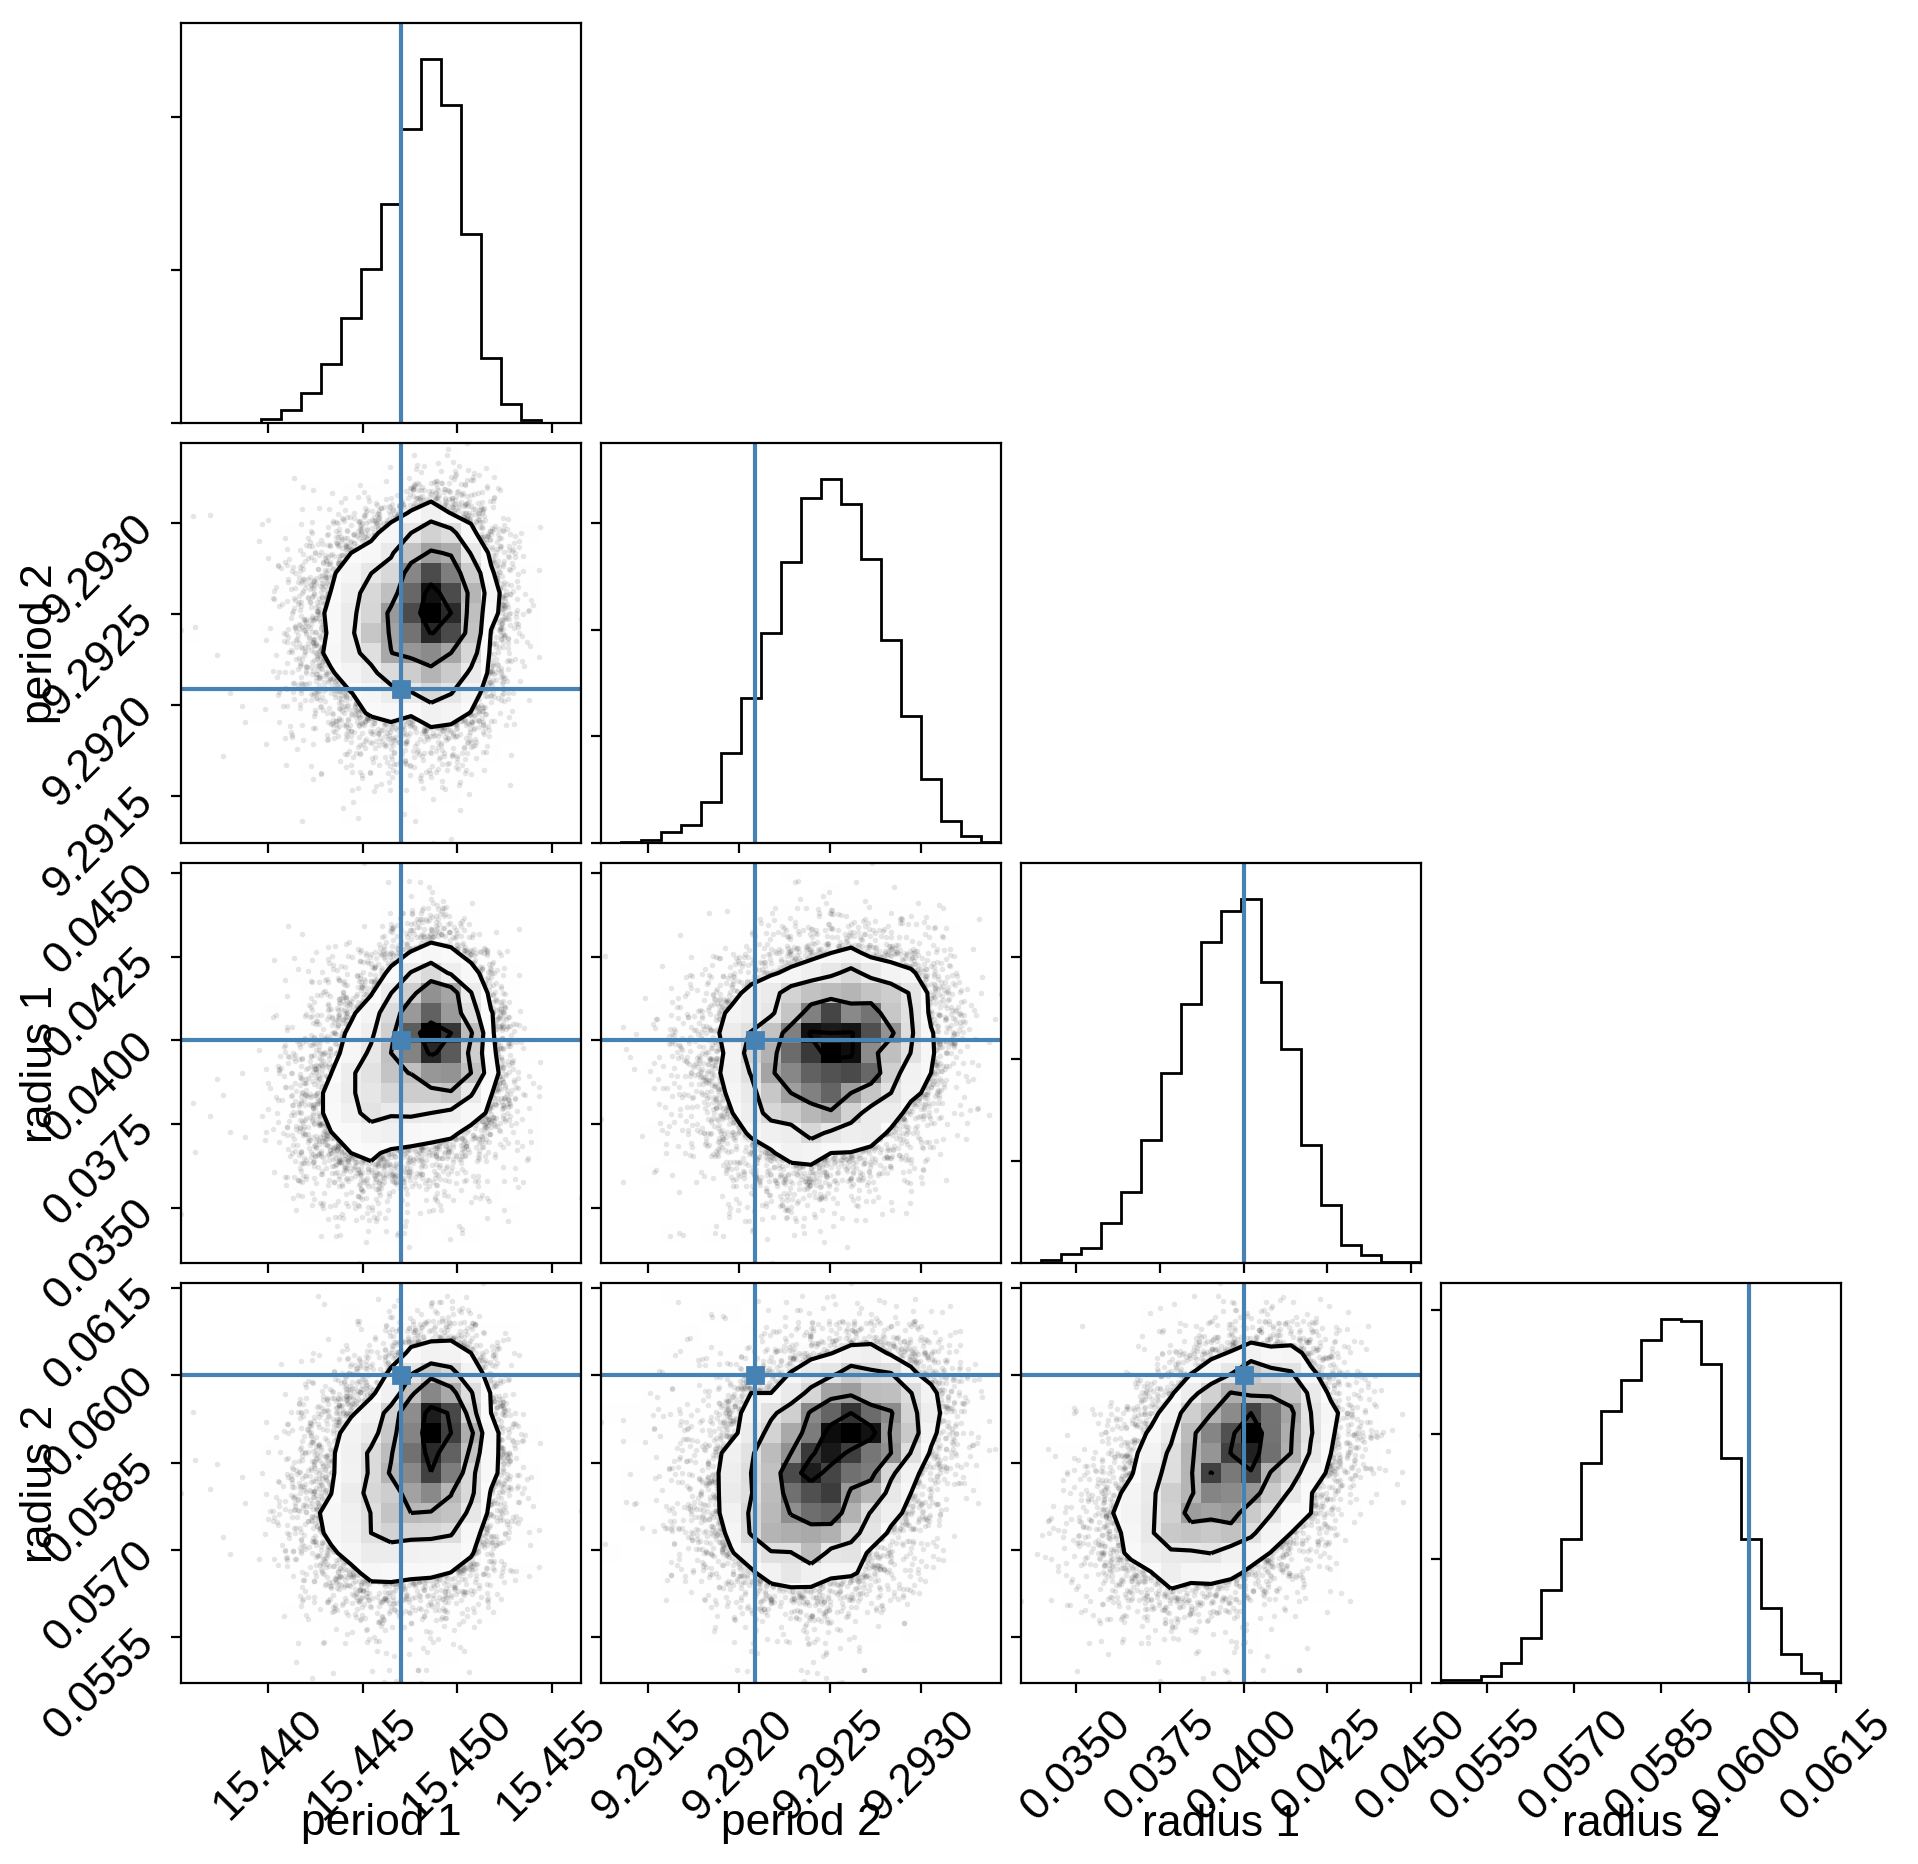

In [9]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(
    samples, truths=truth, labels=["period 1", "period 2", "radius 1", "radius 2"]
);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

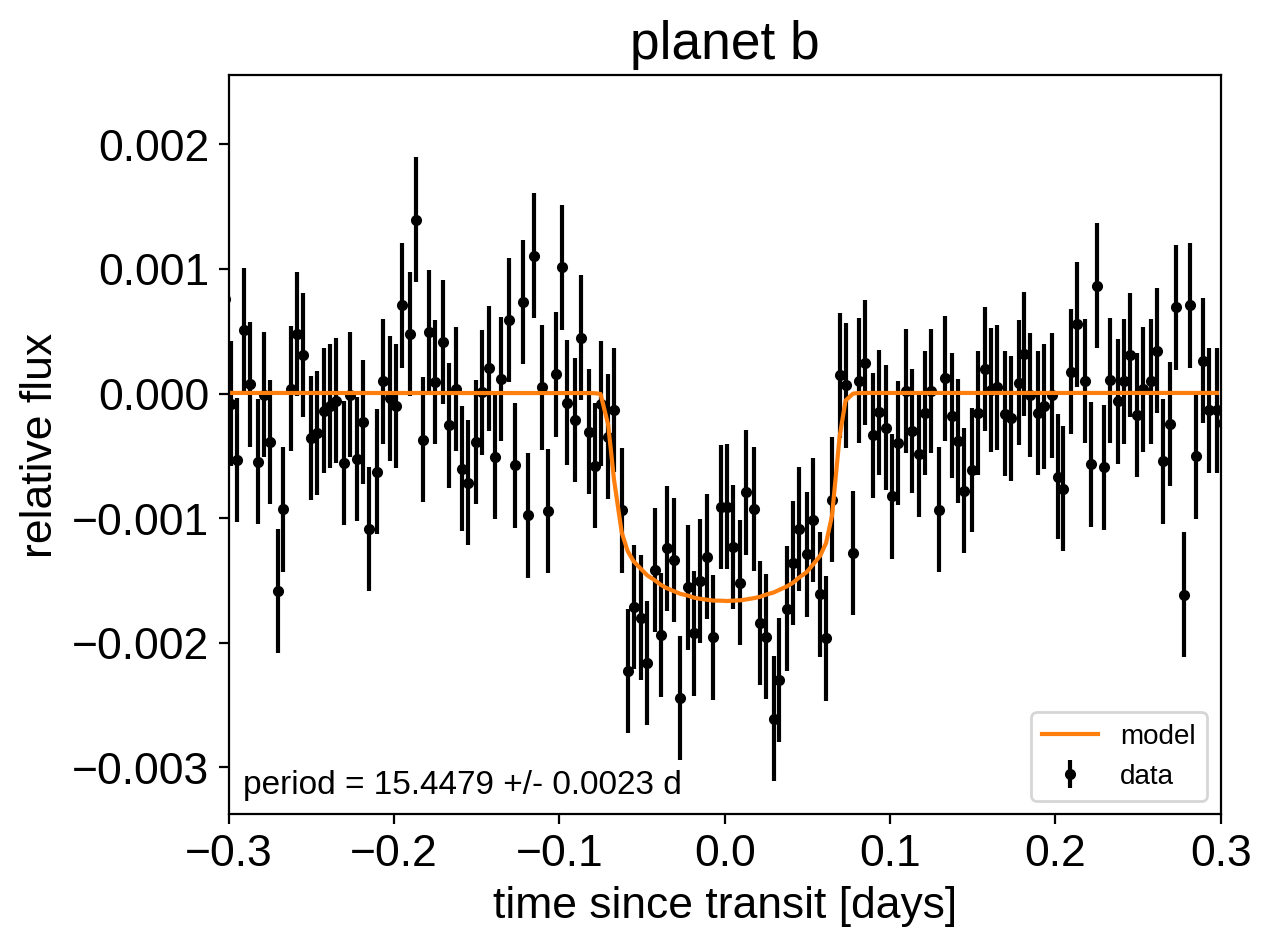

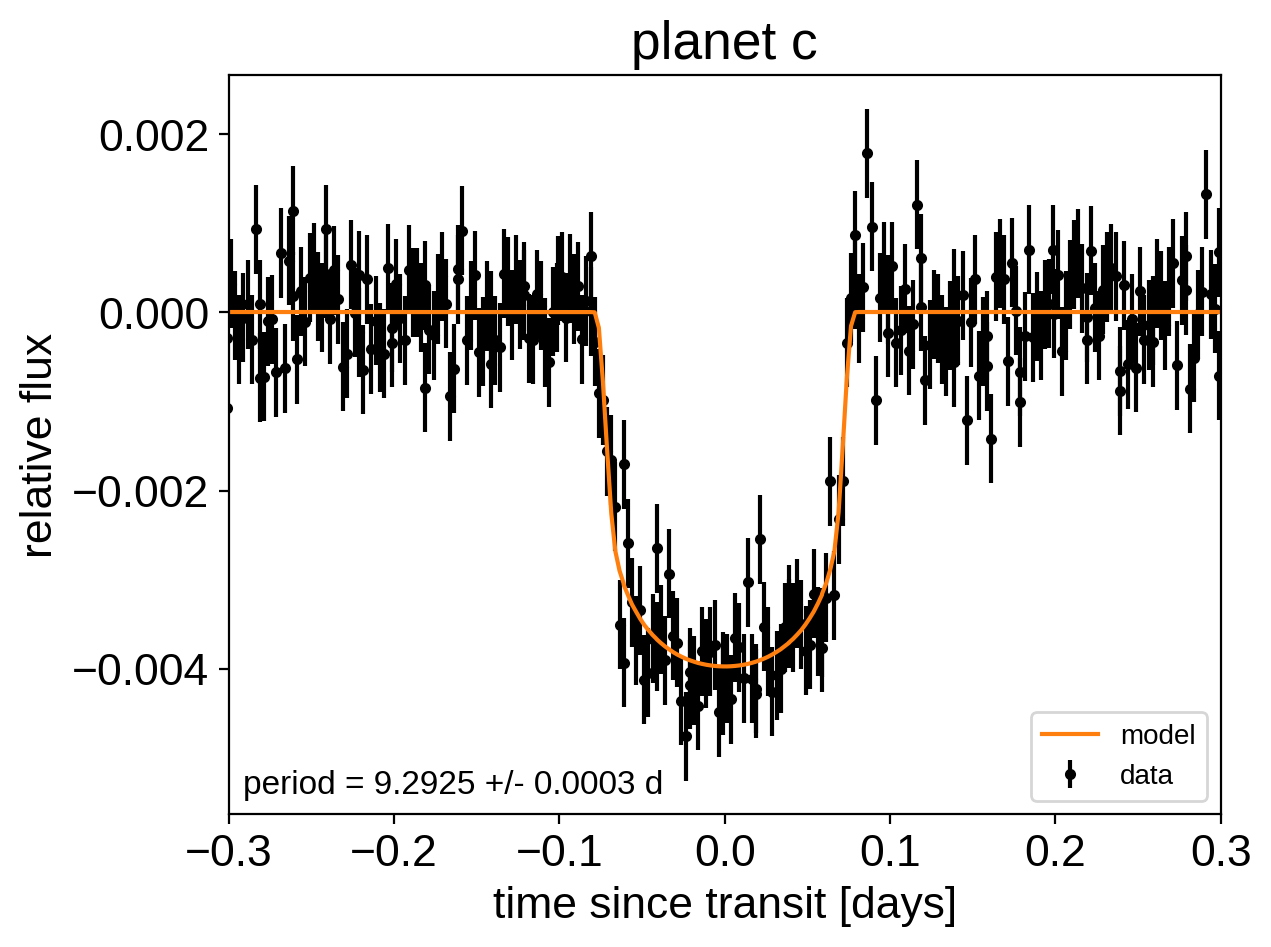

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.1},
   month = sep,
    year = 2019,
     doi = {10.5281/zenodo.3462740},
     url = {https://doi.org/10.5281/zenodo.3462740}
}
...
